# Health Care Analytics Project
---
This notebook runs the anomaly detection code on the health care data set <br>

Anomaly Detection Transformer Paper link- [here](https://iclr.cc/virtual/2022/spotlight/7024) <br>
Anomaly Detection Transformer Code link- [here](https://github.com/thuml/Anomaly-Transformer)

Topics in the notebook <br>

1. Reading the health data
2. DataLoader
3. Embeddings
4. Attention
5. Encoder
6. Main

##### @Notebook author: Sarayu Vyakaranam (svyakara@purdue.edu)

---
---

.

.

---

1. Reading the health data

---

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/no_missing_336.csv',index_col=0)
print(len(data))
data.head(4)

336


,date,heart_rate,steps,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active
0,2021-09-03 00:00:00,96.636364,367,24,20,0,0
1,2021-09-03 01:00:00,92.766667,268,43,17,0,0
2,2021-09-03 02:00:00,81.508475,0,59,0,0,0
3,2021-09-03 03:00:00,80.583333,0,60,0,0,0


In [ ]:
#code from shiyang
import random
def create_random_boolean_vector(length, probability_of_true):
    vector = []
    for i in range(length):
        vector.append(random.random() < probability_of_true)
    return vector
nlength = 336 # total length. If you did the split, change the length here!!!!
#vector is a list
vector = create_random_boolean_vector(nlength, 0.1)
#convert list to array
label = np.array(vector)

In [ ]:
label

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
#data['labels'] = label.tolist() #code to add the labels to the opriginal data

In [ ]:
data.head(3)

,date,heart_rate,steps,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active
0,2021-09-03 00:00:00,96.636364,367,24,20,0,0
1,2021-09-03 01:00:00,92.766667,268,43,17,0,0
2,2021-09-03 02:00:00,81.508475,0,59,0,0,0


In [ ]:
data_wtime = data.drop("date", axis=1) # Drop the time column

In [ ]:
from sklearn.model_selection import train_test_split
X= data_wtime[['heart_rate','steps','minutes_sedentary','minutes_lightly_active','minutes_fairly_active','minutes_very_active']]
y=data_wtime[[]]
#train test split
X_train, X_test,_,_ = train_test_split(X,y ,random_state=104, test_size=0.25, shuffle=True)
print('X_train : ')
print(X_train.head())
print('')
print('X_test : ')
print(X_test.head())
print('')
print('-----lengths-----')
print(len(X_train),len(X_test)) #75-25 split

X_train : 
     heart_rate  steps  minutes_sedentary  minutes_lightly_active  \
90    80.950000     25                 58                       2   
5     82.016667     14                 56                       4   
254   70.066667      0                 60                       0   
104   83.600000      0                 60                       0   
196   79.600000      0                 60                       0   

     minutes_fairly_active  minutes_very_active  
90                       0                    0  
5                        0                    0  
254                      0                    0  
104                      0                    0  
196                      0                    0  

X_test : 
     heart_rate  steps  minutes_sedentary  minutes_lightly_active  \
265   75.133333     35                 57                       3   
9     77.033333     61                 56                       4   
84    77.933333      0                 60               

---
2. DataLoader
---

DataLoader

* __len__ function

The __len__ function in the SMDSegLoader class is a special function that returns the length of the data loader. The length of the data loader is the number of data samples that can be loaded by the data loader.the function returns the number of data samples in the validation set that can be divided into windows of size win_size with a step size of step.

The win_size is subtracted from self.test.shape[0] before dividing by self.step + 1 because the win_size represents the number of data samples in each window. If the division was done without subtracting the win_size, the length of the data loader would be incorrect.
(below doesnt amke sense to me?)
For example, let's say we have a data loader with a window size of 10 and a step size of 2. This means that the first batch will contain the data samples from index 0 to index 9, the second batch will contain the data samples from index 2 to index 11, and so on. The last batch will contain the data samples from index 8 to index 17.
The __len__ function needs to take this into account when calculating the length of the data loader. If the division was done without subtracting the win_size, the length of the data loader would be 18. However, there are only 17 data.(?)

* __getitem__ function

The line of code np.float32(self.train[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size]) in the __getitem__ function of the SMDSegLoader class converts the data sample and ground truth labels to float32 format. This is done because the transformer model expects the data and labels to be in float32 format.

The self.train variable is the training data, and the self.test_labels variable is the ground truth labels for the training data. The index variable is the index of the data sample to return. The self.win_size variable is the window size of the data loader.

why does the test_labels start from 0 but train/val start from idnex- The ground truth labels are always returned as the first win_size values because the transformer model needs to learn to predict the next token based on the previous tokens. If the ground truth labels were not always returned as the first win_size values, then the transformer model would not be able to learn to predict the next token accurately.

during testing, teh ground truth variables for teh current window are only selected

* Batch vs window

Q-> isnt win_size serving the role of a batch_size here? what is teh need for batch size then? <br>
A: Yes, the win_size variable can be considered as a batch size in this case. However, the batch size is a more general concept that refers to the number of data samples that are processed together by the model. The win_size is a specific implementation of the batch size that is used in the SMDSegLoader class.

Q->
then why need teh batch_size in teh get_loader_segment class where the SMAPSegLoader(object) class is called? does a given batch have multiple windows? <br>
A:The batch size is still needed in the get_loader_segment class because it controls the number of data samples that are processed together by the model. The SMDSegLoader class divides the data into windows, but the model still needs to process the windows one at a time.<br>
A given batch can have multiple windows, but the number of windows in a batch will depend on the batch size and the win_size. For example, if the batch size is 10 and the win_size is 2, then a batch will contain 5 windows.

In [ ]:
pip install dataloader

  Preparing metadata (setup.py) ... done
  Created wheel for dataloader: filename=dataloader-2.0-py3-none-any.whl size=10085 sha256=5a3c772a31ff5cf636da50cdac944e42884f4fa126c1248f38d3bd6625b4b682
  Stored in directory: /root/.cache/pip/wheels/60/56/53/2b1c14a2abb6f40f1d59f97461a59e61f326433fac416794de
Successfully built dataloader


In [ ]:
from sklearn.preprocessing import StandardScaler
#using only the SMAP class from the 'data_loader.py' file
class healthdata(object):
    def __init__(self, win_size, step, mode="train"):
        #data_path needs to be set as per data location in local computer. For me is is- '/content/gdrive/MyDrive/Colab Notebooks/'
        #initilizations
        self.mode = mode
        #step is the step size of the data loader. It controls the overlap between subsequent windows. A larger step size will result in less overlap between subsequent batches, while a smaller step size will result in more overlap
        self.step = step
        self.win_size = win_size
        #set scaler
        self.scaler = StandardScaler()
        #add path to train data
        train_data = X_train
        #pass train data to scaler and transform
        self.scaler.fit(train_data)
        train_data = self.scaler.transform(train_data)
        #repeat same for test data
        test_data = X_test
        self.test = self.scaler.transform(test_data)

        #store scaled and transformed train and test data
        self.train = train_data
        #load the test labels
        vector = create_random_boolean_vector(nlength, 0.1)
        #convert list to array
        label = np.array(vector)
        self.test_labels = label
        print("test:", self.test.shape)
        print("train:", self.train.shape)

    def __len__(self):

        #returning the length of input considered
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1 #233
        elif (self.mode == 'test'):
            return (self.test.shape[0] - self.win_size) // self.step + 1
        else:
            print("here")
            return (self.test.shape[0] - self.win_size) // self.win_size + 1


    def __getitem__(self, index):
        index = index * self.step
        '''
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'test'):
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])
        '''
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size])
        elif (self.mode == 'test'):
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])
        else:
            return np.float32(self.test[index // self.step * self.win_size:index // self.step * self.win_size + self.win_size]), np.float32(self.test_labels[index // self.step * self.win_size:index // self.step * self.win_size + self.win_size])

In [ ]:
print(X_train.shape[0]) #note
print(X_train.shape[1])

252
6


In [ ]:
#modified function from 'data_loader.py'
def get_loader_segment(batch_size, win_size=100, step=100, mode='train'):
    batch = batch_size
    dataset = healthdata(win_size, 1, mode)

    shuffle = False
    if mode == 'train':
        shuffle = True

    print(batch_size)
    data_loader = DataLoader(dataset=dataset,batch_size=batch,shuffle=shuffle,num_workers=0)
    return data_loader

can skip: the code below in this section is simplyu to experiment with the data loader, dataloader will be called again in the main model

In [ ]:
train_loader = get_loader_segment(batch_size=8, win_size=20,mode='train')
test_loader = get_loader_segment(batch_size=8, win_size=20,mode='test')
thre_loader = get_loader_segment(batch_size=8, win_size=20, mode='thre')
thre_loader.__len__()

test: (84, 6)
train: (252, 6)
8
test: (84, 6)
train: (252, 6)
8
test: (84, 6)
train: (252, 6)
8
here


1

In [ ]:
#understanding the data loader better and seeing the normalized values
for batch,label in train_loader:
  #note each batch is 8 observations, each observation is 20X6
  print(len(batch))
  print(len(label))
  print(batch)
  print(label)
  print('-------')
  #note each sigma is 1X20, so for the total batch there are 8X20 rows
  print(batch.shape)
  print(label.shape)
  break

8
8
tensor([[[-0.0567, -0.5686,  0.5908, -0.6153,  0.0000,  0.0000],
         [ 0.0121,  0.7564, -0.6003,  0.7331,  0.0000,  0.0000],
         [-0.3908, -0.3105,  0.1144, -0.0760,  0.0000,  0.0000],
         [ 2.3609,  4.4217, -4.1734,  4.7783,  0.0000,  0.0000],
         [ 0.2848, -0.5686,  0.5908, -0.6153,  0.0000,  0.0000],
         [-0.8822, -0.4998,  0.3526, -0.3457,  0.0000,  0.0000],
         [ 0.4445, -0.5686,  0.5908, -0.6153,  0.0000,  0.0000],
         [ 0.9187,  0.4983, -0.3620,  0.4634,  0.0000,  0.0000],
         [ 0.2996, -0.5686,  0.5908, -0.6153,  0.0000,  0.0000],
         [-0.2114, -0.5686,  0.5908, -0.6153,  0.0000,  0.0000],
         [ 0.5797,  1.7373, -2.2677,  2.6208,  0.0000,  0.0000],
         [-0.4350,  0.5843, -0.8385,  1.0027,  0.0000,  0.0000],
         [-0.8478, -0.5686,  0.5908, -0.6153,  0.0000,  0.0000],
         [-0.7642,  0.0337,  0.3526, -0.3457,  0.0000,  0.0000],
         [ 1.1546, -0.5686,  0.5908, -0.6153,  0.0000,  0.0000],
         [ 0.1473, -0

In [ ]:
print(type(train_loader))
print(dir(train_loader))
length_train = 0
length_test = 0
c = 0

#training data
for nth_batch, (batch,_) in enumerate(train_loader):
  #print(len(batch))
  c += 1
  length_train += len(batch)
  if c == 1:
    print('the first batch')
    print(f'length of each batch is (window size)- {len(batch[0])}')
    #each tensor below had 20X25 2D form where 20 is the window size, 25 is fixed in the initial data
    print(batch[0])
    print(batch[1])
    print(batch[2])
    print(batch[3])
    print(batch[4])
    print(batch[5])
    print(batch[6])
    print(batch[7])
    #print(batch[7])
print(length_train)
print(f'the number of rows in training data = {length_train}')
print(f'the number of batches in training data = {nth_batch}')
#test data
for nth_batch, (batch,_) in enumerate(test_loader):
  #print(len(batch))
  length_test += len(batch)
print(f'the number of rows in testing data = {length_test}')
print(f'the number of batches in testing data = {nth_batch}')

<class 'torch.utils.data.dataloader.DataLoader'>
['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_index_sampler', '_is_protocol', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']
the first batch
leng

In [ ]:
233+65

298

---
3. Embeddings
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import math

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        # Compute the positional encodings once in log space.
        super(PositionalEmbedding, self).__init__()

        #d_model is the dimension of the embedding. This means that each token in the embedding layer will have a representation of d_model dimensions.
        #The d_model dimension is a hyperparameter that can be tuned to improve the performance of the model
        #its been set to 128 in the paper
        pe = torch.zeros(max_len, d_model).float()
        #setting require_grad to TRUE allows the gradient of the positional encoding matrix to be calculated during backpropagation.
        #This allows the model to learn the optimal positional encoding matrix for the given task.
        #not sure why its been set to False for now
        pe.require_grad = False

        #The torch.arange() function creates a sequence of numbers from 0 to max_len.
        #The float() function converts the sequence of numbers to floating point numbers
        #The unsqueeze() function adds a new dimension to the tensor.
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        #The div_term tensor is created by first creating a sequence of numbers from 0 to d_model in steps of 2.
        #The sequence of numbers is then converted to floating point numbers and multiplied by a negative exponential function.
        #The negative exponential function is used to create a decaying function that decreases as the position increases.
        #The div_term tensor is then used to create the positional encoding matrix.
        #The positional encoding matrix is a 2D tensor that has the same shape as the input sequences.
        #The values in the positional encoding matrix are calculated by taking the div_term tensor and adding it to a sinusoid function.
        #The sinusoid function is used to create a wave-like pattern that represents the position of the token in the sequence.
        #The positional encoding matrix is then added to the input sequences before they are passed to the model.
        #The positional encoding helps the model learn the temporal relationships between the input sequences.
        #This is important for tasks such as machine translation and natural language understanding,
        #where the order of the words in the sequence is important.
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    #The forward function is not called when the model is initialized.
    #The forward function is only called when the model is used to make predictions or calculate the loss.
    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        #1D convolutional layers are used to extract features from sequences.
        #In the case of the TokenEmbedding class, the 1D convolutional layer is used to extract features from the token sequences.
        #The 1D convolutional layer takes the token sequences as input and outputs a sequence of features.
        #The number of features in the output sequence depends on the number of filters in the 1D convolutional layer.
        #The filters in the 1D convolutional layer are learned during training.

        #kernel_size specifies the size of th ekernel in the 1D convolution
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,kernel_size=3, padding=padding, padding_mode='circular', bias=False)

        #self.modules is a dictionary that contains all of the submodules of the TokenEmbedding class.
        #The TokenEmbedding class has two submodules: positional_encoding and conv1d.
        #The positional_encoding submodule is a positional encoding layer that is used to add positional information to the input sequences.
        #The conv1d submodule is a 1D convolutional layer that is used to extract features from the token sequences.
        #The self.modules attribute is used to access the submodules of the TokenEmbedding class.
        #For example, the following code snippet can be used to access the positional_encoding submodule:
        #     model = TokenEmbedding()
        #     positional_encoding = model.modules['positional_encoding']
        for m in self.modules():
            #if the token embedding exists for the submodule
            if isinstance(m, nn.Conv1d):
                #The nn.init.kaiming_normal_ function in PyTorch is used to initialize the weights of a neural network layer.
                #The function initializes the weights using a normal distribution with a variance that is inversely proportional to the fan-in of the layer.
                #It is often used in conjunction with ReLU activation functions.
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        #forward does 3 things-
        #1. Permutes the input tensor x so that the batch dimension is the first dimension, the sequence dimension is the second dimension, and the feature dimension is the third dimension.
        #2. Pass the permuted tensor x to the tokenConv layer.
        #3. Transposes the output tensor of the tokenConv layer so that the sequence dimension is the first dimension and the feature dimension is the second dimension.
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class DataEmbedding(nn.Module):
    #the c_in taken here is nothing but enc_in size- here input_c = 25 and output_c = 25 (see shell script, these are parameters taken by the parser)
    #note: see build_model in the main.py file- the model is initilaized using the input_c = 25 and output_c = 25
    def __init__(self, c_in, d_model, dropout=0.0):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)


can skip: the code below in this section is simply to experiment with the embeddings, embeddings will be called again in the main model

In [ ]:
# Encoding for the train
enc_in = 6 #embedding size here as there are 6 columns (25 for SMAP)
embedding = DataEmbedding(c_in=enc_in, d_model=512, dropout=0.0) #create an object of class DataEmbedding
print(embedding)
print(type(embedding))

DataEmbedding(
  (value_embedding): TokenEmbedding(
    (tokenConv): Conv1d(6, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
  )
  (position_embedding): PositionalEmbedding()
  (dropout): Dropout(p=0.0, inplace=False)
)
<class '__main__.DataEmbedding'>


In [ ]:
#trying to understand how the embedding class works
#calculate all the embdeddings for the training set
for nth_batch, (batch,sigma) in enumerate(train_loader):
  batch_embedding = embedding(batch)
  #print details for only the first batch
  if nth_batch == 0:
    print(batch_embedding.shape) #batch_size X win_size X d_model=512
    print(len(batch_embedding)) #8
    print(batch_embedding[0].shape) #20 x 512
    print(len(batch_embedding[0])) #20
    print(batch_embedding[1].shape) #20 x 512
    print(len(batch_embedding[1])) #20
    print(batch_embedding[2].shape) #20 x 512
    print(len(batch_embedding[2])) #20
    #'the size of each embedding is 20X512 which is win_size X d_model
    #print a sample embedding
    print(batch_embedding[0]) #20 X 512
  else:
    print(f"calculating embedding for batch number {nth_batch}")

torch.Size([8, 20, 512])
8
torch.Size([20, 512])
20
torch.Size([20, 512])
20
torch.Size([20, 512])
20
tensor([[-0.7407,  0.9948, -0.9496,  ...,  0.4293, -0.2279,  1.4734],
        [ 0.2744,  1.1608,  1.8418,  ...,  2.4348,  0.3173,  1.3905],
        [ 0.2945, -0.5628,  1.4821,  ...,  0.6740, -0.7632,  1.1076],
        ...,
        [ 1.9874,  0.9152,  1.8212,  ...,  3.0008,  3.1786,  1.5899],
        [-1.0686,  0.5923, -3.1183,  ...,  1.6509, -0.3847, -1.5276],
        [-0.0545, -1.5366,  0.0997,  ..., -0.8847, -2.9411,  0.5008]],
       grad_fn=<SelectBackward0>)
calculating embedding for batch number 1
calculating embedding for batch number 2
calculating embedding for batch number 3
calculating embedding for batch number 4
calculating embedding for batch number 5
calculating embedding for batch number 6
calculating embedding for batch number 7
calculating embedding for batch number 8
calculating embedding for batch number 9
calculating embedding for batch number 10
calculating embeddi

note: for each row, teh embedding is calculated of 20X512. Each bath conatins 8 datapoints (or rows) so the entire dimension of a batch is 8X20X512. The 6 (from enc_in is no longer used)

---
4. Attention
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from math import sqrt
import os


In [ ]:
#used to create a mask that prevents the model from attending to future tokens when predicting the current token.
#The mask is a triangular matrix where the diagonal elements are all 1 and the off-diagonal elements are all 0
#This ensures that the model only learns dependencies between the current token and the tokens that have already been seen
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        #define the mask shape- to be B=batch size, L=sequence length, notice L is being passed to the mask function
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


class AnomalyAttention(nn.Module):
    def __init__(self, win_size, mask_flag=True, scale=None, attention_dropout=0.0, output_attention=False):
        super(AnomalyAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        window_size = win_size
        #tensor that stores the distances between all pairs of sequences in the dataset.
        #The distances are calculated using the Euclidean distance metric
        self.distances = torch.zeros((window_size, window_size)).cuda()
        for i in range(window_size):
            for j in range(window_size):
                self.distances[i][j] = abs(i - j)

    def forward(self, queries, keys, values, sigma, attn_mask):
       #B : The batch size= 2 in the paper I think., L : The sequence length=10 i think,
       #H : The hidden size of the transformer=128, E : The embedding size=25. #H = head?
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        #scaling to prevent attention weights from becoming too large
        scale = self.scale or 1. / sqrt(E)

        #the shape of scores is B L H S (Note: I think S denotes the same thing as L, both represent sequence length)
        #The scores tensor contains the attention scores between the queries and keys tensors
        #teh code below specifies the tensor contraction to be performed
        #blhe: The first part of the string specifies the shape of the first tensor, which is the queries tensor. The blhe shape indicates that the queries tensor has four dimensions: batch size (b), sequence length (l), hidden size (h), and embedding size (e).
        #bshe: The second part of the string specifies the shape of the second tensor, which is the keys tensor. The bshe shape indicates that the keys tensor has the same shape as the queries tensor.
        #->: The -> symbol indicates that the tensor contractions should be performed.
        #bhls: The third part of the string specifies the shape of the output tensor, which is the scores tensor. The bhls shape indicates that the scores tensor has four dimensions: batch size (b), sequence length (l), hidden size (h), and sequence length (l) again.
        #the following tensor contractions are perfomed-
        #1. The queries tensor is multiplied by the keys tensor.
        #2. The product of the queries tensor and the keys tensor is summed over the embedding size dimension.
        #3. The sum of the products is then reshaped to have the shape of the scores tensor.

        #note: S and E need not be same
        scores = torch.einsum("blhe,bshe->bhls", queries, keys)


        #apply mask if needed
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        #scale
        attn = scale * scores

        sigma = sigma.transpose(1, 2)  # B L H ->  B H L
        window_size = attn.shape[-1]
        sigma = torch.sigmoid(sigma * 5) + 1e-5
        sigma = torch.pow(3, sigma) - 1
        sigma = sigma.unsqueeze(-1).repeat(1, 1, 1, window_size)  # B H L L #I think this is the same dimension as the scores
        prior = self.distances.unsqueeze(0).unsqueeze(0).repeat(sigma.shape[0], sigma.shape[1], 1, 1).cuda()
        prior = 1.0 / (math.sqrt(2 * math.pi) * sigma) * torch.exp(-prior ** 2 / 2 / (sigma ** 2))

        series = self.dropout(torch.softmax(attn, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", series, values)

        if self.output_attention:
            return (V.contiguous(), series, prior, sigma)
        else:
            return (V.contiguous(), None)


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)
        self.norm = nn.LayerNorm(d_model)
        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model,
                                          d_keys * n_heads)
        self.key_projection = nn.Linear(d_model,
                                        d_keys * n_heads)
        self.value_projection = nn.Linear(d_model,
                                          d_values * n_heads)
        self.sigma_projection = nn.Linear(d_model,
                                          n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)

        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        x = queries
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)
        sigma = self.sigma_projection(x).view(B, L, H)

        out, series, prior, sigma = self.inner_attention(
            queries,
            keys,
            values,
            sigma,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), series, prior, sigma


can skip: the code below in this section is simply to experiment with the attention, attention will be called again in the main model

In [ ]:
#creating a smaple attentionlayer to understand class structure
y = AnomalyAttention(win_size=20, mask_flag=False, scale=None, attention_dropout=0.0, output_attention=False)
y

AnomalyAttention(
  (dropout): Dropout(p=0.0, inplace=False)
)

In [ ]:
b = AttentionLayer(y,d_model=512,n_heads=8)
b

AttentionLayer(
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (inner_attention): AnomalyAttention(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (query_projection): Linear(in_features=512, out_features=512, bias=True)
  (key_projection): Linear(in_features=512, out_features=512, bias=True)
  (value_projection): Linear(in_features=512, out_features=512, bias=True)
  (sigma_projection): Linear(in_features=512, out_features=8, bias=True)
  (out_projection): Linear(in_features=512, out_features=512, bias=True)
)

---
5. Encoder
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        ## -- what is dff compared to d_model
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        #convolution for learning important imformation
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)

        #Layer normalization is a technique used to normalize
        #the activations of a layer, which can help to improve the stability and performance of the model
        #imporves performance of models
        self.norm2 = nn.LayerNorm(d_model)
        #dropout prevent overfitting in neural networks
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    ## -- how is forward called immedietly?
    def forward(self, x, attn_mask=None):
        new_x, attn, mask, sigma = self.attention(x, x, x,attn_mask=attn_mask)
        #dropout prevent overfitting in neural networks
        x = x + self.dropout(new_x)
        #again norm followed by dropout
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        ## -- why taking a combination of x and y?
        return self.norm2(x + y), attn, mask, sigma


class Encoder(nn.Module):
    #note the EncoderLayer is passed to the encoder
    def __init__(self, attn_layers, norm_layer=None):
        super(Encoder, self).__init__()

        self.attn_layers = nn.ModuleList(attn_layers)
        self.norm = norm_layer

    #only appending in teh encoder layer
    def forward(self, x, attn_mask=None):
        #note here B= batch, L= layers stacked on top of each other, D=?

        ### x [B, L, D]
        series_list = []
        prior_list = []
        sigma_list = []
        for attn_layer in self.attn_layers:
            x, series, prior, sigma = attn_layer(x, attn_mask=attn_mask)
            series_list.append(series)
            prior_list.append(prior)
            sigma_list.append(sigma)
        if self.norm is not None:
            x = self.norm(x)
        #returns appended
        return x, series_list, prior_list, sigma_list


class AnomalyTransformer(nn.Module):
    def __init__(self, win_size, enc_in, c_out, d_model=512, n_heads=8, e_layers=3, d_ff=512,
                 dropout=0.0, activation='gelu', output_attention=True):
        super(AnomalyTransformer, self).__init__()
        self.output_attention = output_attention

        # Encoding
        self.embedding = DataEmbedding(enc_in, d_model, dropout)

        # Encoder
        #the anomaloy transformer is created by passing the anomaly attention
        #inside the attention layer which is passed to encoder layer where
        #its further passed to the encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        AnomalyAttention(win_size, False, attention_dropout=dropout, output_attention=output_attention),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )

        ## -- what is this projection
        self.projection = nn.Linear(d_model, c_out, bias=True)

    def forward(self, x):
        enc_out = self.embedding(x)
        enc_out, series, prior, sigmas = self.encoder(enc_out)
        enc_out = self.projection(enc_out)

        if self.output_attention:
            return enc_out, series, prior, sigmas
        else:
            return enc_out  # [B, L, D]


---
6. Main
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
def my_kl_loss(p, q):

    #calculates the difference between the logarithms of p and q and multiplies into p
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))

    #take the sum and the mean across columns
    ## --not sure why mean is again dim = 1
    return torch.mean(torch.sum(res, dim=-1), dim=1)

In [ ]:
def adjust_learning_rate(optimizer, epoch, lr_):
    #create a dictionary for epoch
    lr_adjust = {epoch: lr_ * (0.5 ** ((epoch - 1) // 1))}
    #the learning rate is adjusted according to teh number of epochs completed
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

omitted early stopping class

In [ ]:
class Solver(object):
    DEFAULTS = {}

    def __init__(self, config):

        self.__dict__.update(Solver.DEFAULTS, **config)

        #only considered the loaders required
        #self.train_loader = get_loader_segment(self.data_path, batch_size=self.batch_size, win_size=self.win_size,mode='train',dataset=self.dataset)
        self.train_loader = get_loader_segment(batch_size=self.batch_size, win_size=self.win_size,mode='train')
        #self.vali_loader = get_loader_segment(self.data_path, batch_size=self.batch_size, win_size=self.win_size,mode='val',dataset=self.dataset)
        #self.test_loader = get_loader_segment(self.data_path, batch_size=self.batch_size, win_size=self.win_size,mode='test',dataset=self.dataset)
        self.test_loader = get_loader_segment(batch_size=self.batch_size, win_size=self.win_size,mode='test')
        #self.thre_loader = get_loader_segment(self.data_path, batch_size=self.batch_size, win_size=self.win_size,mode='thre',dataset=self.dataset)
        self.thre_loader = get_loader_segment(batch_size=self.batch_size, win_size=self.win_size,mode='thre')

        self.build_model()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.criterion = nn.MSELoss()

    def build_model(self):
        self.model = AnomalyTransformer(win_size=self.win_size, enc_in=self.input_c, c_out=self.output_c, e_layers=3)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        if torch.cuda.is_available():
            self.model.cuda()

    def vali(self, vali_loader):
        self.model.eval()

        loss_1 = []
        loss_2 = []
        for i, (input_data, _) in enumerate(vali_loader):
            input = input_data.float().to(self.device)
            output, series, prior, _ = self.model(input)
            series_loss = 0.0
            prior_loss = 0.0
            for u in range(len(prior)):
                series_loss += (torch.mean(my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                               self.win_size)).detach())) + torch.mean(
                    my_kl_loss(
                        (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                self.win_size)).detach(),
                        series[u])))
                prior_loss += (torch.mean(
                    my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                       self.win_size)),
                               series[u].detach())) + torch.mean(
                    my_kl_loss(series[u].detach(),
                               (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                       self.win_size)))))
            series_loss = series_loss / len(prior)
            prior_loss = prior_loss / len(prior)

            rec_loss = self.criterion(output, input)
            loss_1.append((rec_loss - self.k * series_loss).item())
            loss_2.append((rec_loss + self.k * prior_loss).item())

        return np.average(loss_1), np.average(loss_2)


    def train(self):

        print("======================TRAIN MODE======================")

        time_now = time.time()
        #path = self.model_save_path
        #if not os.path.exists(path):
            #os.makedirs(path)
        #early_stopping = EarlyStopping(patience=3, verbose=True, dataset_name=self.dataset)
        train_steps = len(self.train_loader)

        for epoch in range(self.num_epochs):
            iter_count = 0
            loss1_list = []

            epoch_time = time.time()
            self.model.train()
            #for i, (input_data, labels) in enumerate(self.train_loader):
            for i, (input_data) in enumerate(self.train_loader):

                self.optimizer.zero_grad()
                iter_count += 1
                input = input_data.float().to(self.device)

                output, series, prior, _ = self.model(input)

                # calculate Association discrepancy
                series_loss = 0.0
                prior_loss = 0.0
                for u in range(len(prior)):
                    series_loss += (torch.mean(my_kl_loss(series[u], (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)).detach())) + torch.mean(my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)).detach(),series[u])))
                    prior_loss += (torch.mean(my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)),series[u].detach())) + torch.mean(my_kl_loss(series[u].detach(), (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)))))
                series_loss = series_loss / len(prior)
                prior_loss = prior_loss / len(prior)

                rec_loss = self.criterion(output, input)

                loss1_list.append((rec_loss - self.k * series_loss).item())
                loss1 = rec_loss - self.k * series_loss
                loss2 = rec_loss + self.k * prior_loss

                if (i + 1) % 100 == 0:
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.num_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

                # Minimax strategy
                loss1.backward(retain_graph=True)
                loss2.backward()
                self.optimizer.step()

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(loss1_list)

            vali_loss1, vali_loss2 = self.vali(self.test_loader)


            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} ".format(epoch + 1, train_steps, train_loss, vali_loss1))
            '''
            early_stopping(vali_loss1, vali_loss2, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break
            adjust_learning_rate(self.optimizer, epoch + 1, self.lr)
            '''

    def test(self):
        #self.model.load_state_dict(
            #torch.load(
                #os.path.join(str(self.model_save_path), str(self.dataset) + '_checkpoint.pth')))
        self.model.eval()
        temperature = 50

        print("======================TEST MODE======================")

        criterion = nn.MSELoss(reduce=False)

        # (1) stastic on the train set
        attens_energy = []
        #for i, (input_data, labels) in enumerate(self.train_loader):
        for i, (input_data, labels) in enumerate(self.test_loader):
            input = input_data.float().to(self.device)
            output, series, prior, _ = self.model(input)
            loss = torch.mean(criterion(input, output), dim=-1)
            series_loss = 0.0
            prior_loss = 0.0
            for u in range(len(prior)):
                if u == 0:
                    series_loss = my_kl_loss(series[u], (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)).detach()) * temperature
                    prior_loss = my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)),series[u].detach()) * temperature
                else:
                    series_loss += my_kl_loss(series[u], (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)).detach()) * temperature
                    prior_loss += my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)),series[u].detach()) * temperature

            metric = torch.softmax((-series_loss - prior_loss), dim=-1)
            cri = metric * loss
            cri = cri.detach().cpu().numpy()
            attens_energy.append(cri)

        attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
        train_energy = np.array(attens_energy)

        # (2) find the threshold
        attens_energy = []
        for i, (input_data, labels) in enumerate(self.thre_loader):
            input = input_data.float().to(self.device)
            output, series, prior, _ = self.model(input)

            loss = torch.mean(criterion(input, output), dim=-1)

            series_loss = 0.0
            prior_loss = 0.0
            for u in range(len(prior)):
                if u == 0:
                    series_loss = my_kl_loss(series[u], (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)).detach()) * temperature
                    prior_loss = my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)),series[u].detach()) * temperature
                else:
                    series_loss += my_kl_loss(series[u], (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)).detach()) * temperature
                    prior_loss += my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)),series[u].detach()) * temperature
            # Metric
            metric = torch.softmax((-series_loss - prior_loss), dim=-1)
            cri = metric * loss
            cri = cri.detach().cpu().numpy()
            attens_energy.append(cri)

        attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
        test_energy = np.array(attens_energy)
        combined_energy = np.concatenate([train_energy, test_energy], axis=0)
        thresh = np.percentile(combined_energy, 100 - self.anormly_ratio)
        print("Threshold :", thresh)

        # (3) evaluation on the test set
        test_labels = []
        attens_energy = []
        for i, (input_data, labels) in enumerate(self.thre_loader):
            input = input_data.float().to(self.device)
            output, series, prior, _ = self.model(input)

            loss = torch.mean(criterion(input, output), dim=-1)

            series_loss = 0.0
            prior_loss = 0.0
            for u in range(len(prior)):
                if u == 0:
                    series_loss = my_kl_loss(series[u], (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)).detach()) * temperature
                    prior_loss = my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)),series[u].detach()) * temperature
                else:
                    series_loss += my_kl_loss(series[u], (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)).detach()) * temperature
                    prior_loss += my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,self.win_size)),
                        series[u].detach()) * temperature
            metric = torch.softmax((-series_loss - prior_loss), dim=-1)

            cri = metric * loss
            cri = cri.detach().cpu().numpy()
            attens_energy.append(cri)
            test_labels.append(labels)

        attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
        test_labels = np.concatenate(test_labels, axis=0).reshape(-1)
        test_energy = np.array(attens_energy)
        test_labels = np.array(test_labels)

        pred = (test_energy > thresh).astype(int)

        gt = test_labels.astype(int)

        print("pred:   ", pred.shape)
        print("gt:     ", gt.shape)

        '''
        # detection adjustment
        anomaly_state = False
        for i in range(len(gt)):
            if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
                anomaly_state = True
                for j in range(i, 0, -1):
                    if gt[j] == 0:
                        break
                    else:
                        if pred[j] == 0:
                            pred[j] = 1
                for j in range(i, len(gt)):
                    if gt[j] == 0:
                        break
                    else:
                        if pred[j] == 0:
                            pred[j] = 1
            elif gt[i] == 0:
                anomaly_state = False
            if anomaly_state:
                pred[i] = 1
        '''
        pred = np.array(pred)
        gt = np.array(gt)
        print("pred shape: ", pred.shape)
        print("gt shape:   ", gt.shape)
        print(f"pred: {pred}")
        print(f"gt: {gt}")


        fpr, tpr, _ = metrics.roc_curve(gt,  test_energy)
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        from sklearn.metrics import precision_recall_fscore_support
        from sklearn.metrics import accuracy_score
        accuracy = accuracy_score(gt, pred)
        precision, recall, f_score, support = precision_recall_fscore_support(gt, pred,average='binary')
        print(
            "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
                accuracy, precision,
                recall, f_score))

        return accuracy, precision, recall, f_score

In [ ]:
def main(config):
    #cudnn.benchmark = True
    #if (not os.path.exists(config.model_save_path)):
        #mkdir(config.model_save_path)
    solver = Solver(config)

    #if config.mode == 'train':
    solver.train()
    #elif config.mode == 'test':
    solver.test()

    return solver

In [ ]:
config = {"lr": 1e-4, "num_epochs": 2, "win_size":20,"input_c":6, "output_c":6,"batch_size":8,"anormly_ratio":4.00,"k":3}

In [ ]:
#Solver({"lr": 1e-4, "num_epochs": 2, "win_size":20,"input_c":6, "output_c":6,"batch_size":8,"anormly_ratio":4.00})

test: (84, 6)
train: (252, 6)
8
test: (84, 6)
train: (252, 6)
8
test: (84, 6)
train: (252, 6)
8
======================TRAIN MODE======================
Epoch: 1 cost time: 0.7145488262176514
Epoch: 1, Steps: 30 | Train Loss: -22.1338828 Vali Loss: -32.9120242 
Epoch: 2 cost time: 0.6680958271026611
Epoch: 2, Steps: 30 | Train Loss: -35.9658021 Vali Loss: -36.2538478 
======================TEST MODE======================
here
Threshold : 0.038866608589887615
here
pred:    (80,)
gt:      (80,)
pred shape:  (80,)
gt shape:    (80,)
pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0]
gt: [0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0
 0 0 1 0 1 0]


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


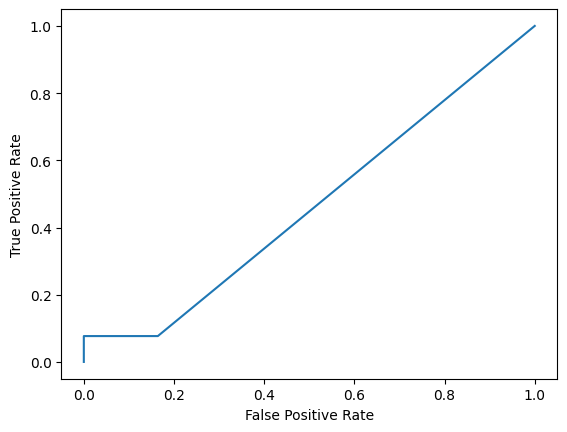

Accuracy : 0.8250, Precision : 0.3333, Recall : 0.0769, F-score : 0.1250 


In [ ]:
main(config)